In [3]:
'''
#Gigacow-tools# - preprocessing
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#access data from local directory
dataDir = "E:/Data/processed/"
gigacow_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'BreedName', 'Age']
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir + 'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir + 'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir + 'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

5613    11903
6197    11250
4478    11054
3757    10907
2423    10864
3147    10083
4504    10016
5147     9758
3121     9518
5046     9390
Name: Gigacow_Cow_Id, dtype: int64


In [15]:
#select single cow from the traffic table
traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == 129]
traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
traffic_single_cow.index = range(len(traffic_single_cow))

'''
    Extract Milking Event and its most recent traffic event to calculate T2-T1
    T1: Entry time into the Mjolkfalla
    T2: Entry time into the milking robot
    T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
'''
# locate mikling event by searching 'kg' keyword in traffic result
# the most recent traffic event to milking event should be pre_milking event
# need to filter out records with gate failure
track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
milking_index_list = track_milking.index[track_milking.values == True].tolist()
pre_milking_index_list = [x-1 for x in milking_index_list]
milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

# drop rows that the gate failed to detect cows but have milking result
# previous area in milking_traffic table should only be Mjolkfalla
# previous area in pre_milking_traffic table should not be Mjolkfalla
failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
failed_list_1_pre = [x-1 for x in failed_list_1_milk]
failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
failed_list_2_milk = [x+1 for x in failed_list_2_pre]
# traffic result in pre_milking_traffic table should contain Mjolkfalla
track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
failed_list_3_milk = [x+1 for x in failed_list_3_pre]

# remove failed records based on index list
milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
# concatenate two tables to track the traffic directly
all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
#rename table columns for merging
milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
# unify the index of two tables
milking_traffic.index = range(len(milking_traffic))
pre_milking_traffic.index = range(len(pre_milking_traffic))
# inert "pre_traffic_milking" to milking traffic table
milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
# calculate T2-T1
milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

#extract traffic result(milk production)
milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

# merge all the other features into milking_traffic table
milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])
single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'])

# drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)

# write the collection result to local directory
single_cow_collection = single_cow_merge[['Gigacow_Cow_Id', 'BreedName', 'Age', 'FarmName_Pseudo', 'GroupName', 'TrafficDeviceName', 'MilkProduction', 'timeDelta_Seconds', 'LactationNumber', 'DaysInMilk']]
single_cow_collection.to_csv(dataDir + 'single_cow_collection.csv')

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_60812\402855239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_60812\402855239.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_60812\402855239.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

<Figure size 432x288 with 0 Axes>

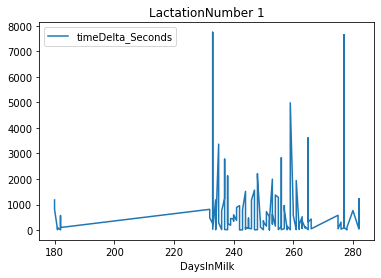

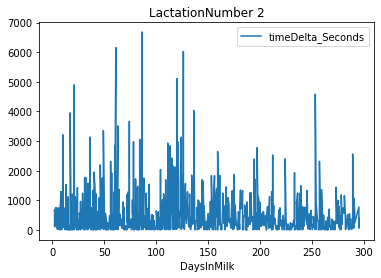

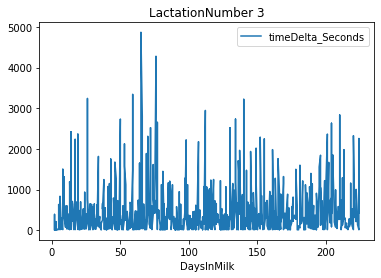

In [16]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
plt.figure()
single_cow_collection.loc[single_cow_collection.LactationNumber == 1].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 1')
single_cow_collection.loc[single_cow_collection.LactationNumber == 2].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 2')
single_cow_collection.loc[single_cow_collection.LactationNumber == 3].plot(x="DaysInMilk", y="timeDelta_Seconds", kind='line', title='LactationNumber 3')
plt.show()


In [17]:
#all_milking_traffic.to_csv(dataDir+'all_milking_traffic.csv')
all_milking_traffic
#pre_milking_traffic.to_csv(dataDir+'pre_milking_traffic.csv')
pre_milking_traffic
#milking_traffic.to_csv(dataDir+'milking_traffic.csv')
milking_traffic
#single_cow_merge.to_csv(dataDir + 'single_cow_merge.csv')
single_cow_merge

,Traffic_Id,FarmName_Pseudo,Gigacow_Cow_Id,GroupName,MilkingEventDateTime,Pre_MilkingEventDateTime,PreviousArea,RoundedSecondsTimeInArea,TrafficDeviceName,MilkProduction,MilkingInterval_totalSeconds,timeDelta_Seconds,MilkingDate,LactationInfoDate,LactationNumber,DaysInMilk,BreedName,Age
0,518364,a624fb9a,129,VMS 1,2020-08-17 10:52:55,2020-08-17 10:33:16,Mjolkfalla,1140,VMS 1,15.31,47520.0,1179.0,2020-08-17,2020-08-17,1,180.0,1,4.77
1,307150,a624fb9a,129,VMS 1,2020-08-17 18:41:18,2020-08-17 18:27:40,Mjolkfalla,780,VMS 1,9.98,27600.0,818.0,2020-08-17,2020-08-17,1,180.0,1,4.77
2,516645,a624fb9a,129,VMS 1,2020-08-18 00:57:31,2020-08-18 00:57:18,Mjolkfalla,0,VMS 1,8.35,22140.0,13.0,2020-08-18,2020-08-18,1,181.0,1,4.77
3,570026,a624fb9a,129,VMS 1,2020-08-18 10:25:20,2020-08-18 10:24:19,Mjolkfalla,60,VMS 1,12.69,33720.0,61.0,2020-08-18,2020-08-18,1,181.0,1,4.77
4,108524,a624fb9a,129,VMS 1,2020-08-18 18:35:57,2020-08-18 18:34:23,Mjolkfalla,60,VMS 1,10.68,28980.0,94.0,2020-08-18,2020-08-18,1,181.0,1,4.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,4581487,a624fb9a,129,VMS 1,2022-08-22 12:59:54,2022-08-22 12:57:02,Mjolkfalla,120,MS2,15.94,37560.0,172.0,2022-08-22,2022-08-22,3,223.0,1,4.77
1680,3379343,a624fb9a,129,VMS 1,2022-08-22 19:27:04,2022-08-22 19:24:48,Mjolkfalla,120,MS2,9.69,22740.0,136.0,2022-08-22,2022-08-22,3,223.0,1,4.77
1681,10472864,a624fb9a,129,VMS 1,2022-08-23 06:24:17,2022-08-23 06:24:06,Mjolkfalla,0,MS2,14.98,39060.0,11.0,2022-08-23,2022-08-23,3,224.0,1,4.77
1682,1232746,a624fb9a,129,VMS 1,2022-08-23 13:27:01,2022-08-23 12:49:26,Mjolkfalla,2220,MS2,10.65,24900.0,2255.0,2022-08-23,2022-08-23,3,224.0,1,4.77


In [10]:
# Select cows with sufficient data points on consecutive lactation periods
# Try to collect cow's data that contain milking events between lactation periods 1~2
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
lactation = pd.read_csv(dataDir + 'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
# select records that contains lactation period 1
lactation_select1 = lactation.loc[lactation['LactationNumber'] == 1]
selected1 = lactation_select1.Gigacow_Cow_Id.value_counts(ascending=True)
selected1 = selected1.loc[(selected1.values > 280) & (selected1.values < 370)]
list1 = selected1.index.tolist()
# select records that contains lactation period 2
lactation_select2 = lactation.loc[lactation['LactationNumber'] == 2]
selected2 = lactation_select2.Gigacow_Cow_Id.value_counts(ascending=True)
selected2 = selected2.loc[(selected2.values > 280) & (selected2.values < 370)]
list2 = selected2.index.tolist()
cow_list = list(set(list1) & set(list2))

In [11]:
cow_list

[636,
 129,
 2569,
 1555,
 2195,
 919,
 920,
 5147,
 1181,
 560,
 562,
 1846,
 697,
 6485,
 4825,
 5470,
 478,
 5477,
 6380,
 2423,
 4220]

In [12]:
print(selected1.count())
selected1

64


3993    281
866     281
1247    283
562     285
1551    286
       ... 
5235    359
2423    359
1393    359
697     360
3207    369
Name: Gigacow_Cow_Id, Length: 64, dtype: int64

In [46]:
print(selected2.count())
selected2

40


3127    302
3641    303
1032    309
3113    311
926     316
478     320
6363    323
6352    325
3971    326
1846    328
560     330
2195    331
2354    332
5470    333
636     334
5147    334
4379    335
920     336
3121    336
5183    337
562     339
2423    340
802     341
4261    342
6027    342
4220    342
2712    345
5477    347
5343    349
1287    349
919     350
3844    350
2001    351
4825    352
182     355
5633    355
129     356
1582    358
1555    358
1583    359
Name: Gigacow_Cow_Id, dtype: int64

In [19]:
lactation_select

,FarmName_Pseudo,AnimalNumber,Gigacow_Cow_Id,LactationInfoDate,LactationNumber,DaysInMilk
0,a624fb9a,1394,5160,2021-09-08,1,67.0
1,f454e660,622,4311,2022-04-11,1,118.0
4,a624fb9a,1368,3207,2021-09-26,1,254.0
7,a624fb9a,1394,5160,2021-11-29,1,149.0
12,f454e660,483,3641,2021-02-26,1,259.0
...,...,...,...,...,...,...
192792,f454e660,489,4906,2021-09-16,1,368.0
192795,a624fb9a,1383,5465,2021-08-01,1,64.0
192796,a624fb9a,1426,4195,2022-04-20,1,47.0
192799,a624fb9a,1297,560,2020-12-27,1,352.0
